# **Importing libraries and data**

In [23]:
import csv
import math
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import sklearn

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from yellowbrick.regressor import ResidualsPlot
from sklearn import linear_model
from pprint import pprint
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button style="color:"black";right:75%;" onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [28]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################
####### Load ADS using name and path

load_ads = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/DPL_Curated_Datasets/DPL_Master_dataset_storm_all_v2.3.csv')
load_ads['TIME_OF_FIRST_CALL'] = pd.to_datetime(load_ads['TIME_OF_FIRST_CALL'], infer_datetime_format = True, errors = 'coerce')

# Getting info for training dataset
event_ = load_ads['EVENT']
outage_id = load_ads['OUTAGE_ID']

# Dropping unnecessary columns
load_ads = load_ads.drop(columns= ['Unnamed: 0','OUTAGE_ID', 'CIRCUIT', 'TIME_OF_FIRST_CALL', 'DEVICE',
                                   'STORM_TYPE','EVENT', 'DATE','DEVICESIZE'])
print(load_ads.shape)
display(load_ads.head())

(79979, 139)


,PHASE_A,PHASE_B,PHASE_C,PHASE_T,LFS_CUSTS,MED_CUSTS,EMR_CUSTS,UTL_CUSTS,MAJ_CUSTS,GOV_CUSTS,LRT_CUSTS,WIREDOWN_PTH,WIREDOWN_PTP,TREEONWIRE_PTH,TREEONWIRE_PTP,BROKENPOLE,FIREEXPLOSION,DAMAGEDTRANS,PRIORITY,CONFIDENCE,CUSTSTILLOUT,TTR,MAJOR,TORD_False,TORD_True,ACCOUNT_TYPE_COM,ACCOUNT_TYPE_CUS,ACCOUNT_TYPE_GOV,ACCOUNT_TYPE_IND,ACCOUNT_TYPE_RES,Day_flag,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OTG,weekday,Weekend_flag,Marker_Location,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Min_Distance_service_Center,Nearest_service_center,cldCvrMin,cldCvrAvg,cldCvrMax,dewPtMin,dewPtAvg,dewPtMax,feelsLikeMin,feelsLikeAvg,feelsLikeMax,heatIndexMin,heatIndexAvg,heatIndexMax,mslPresMin,mslPresAvg,mslPresMax,precip,radSolarMin,radSolarAvg,radSolarMax,radSolarTot,relHumMin,relHumAvg,relHumMax,sfcPresMin,sfcPresAvg,sfcPresMax,snowfall,spcHumMin,spcHumAvg,spcHumMax,tempMin,tempAvg,tempMax,windChillMin,windChillAvg,windChillMax,windDirAvg,windDir80mAvg,windDir100mAvg,windSpdMin,windSpdAvg,windSpdMax,windSpd80mMin,windSpd80mAvg,windSpd80mMax,windSpd100mMin,windSpd100mAvg,windSpd100mMax,wetBulbMin,wetBulbAvg,wetBulbMax,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,DEVICETYPE,TOPFUSE,TOTCUST_A,TOTCUST_B,TOTCUST_C,TOTCUST_T,VOLTAGE,UNDERGD,NORMALLYOPEN,TOTKVA_A,TOTKVA_B,TOTKVA_C,Total_Crew_dispatched,Total_Crew_available,Line_crew,Service_crew,Substation_crew,Network_crew,Contractor,rank,rank_cd,Slope_outages,Slope_ROC_outages,max_ROC_outages,max_index_ROC,weight_ROC,Total_Customers,Total_Key_Customers,Month_Sin,Month_Cos,Pole,Nearest_service_center_mod
0,True,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,False,H,0,351.40,0.0,8.0,0.0,False,False,False,False,False,False,0.258819,0.965926,1.0,Tuesday,False,Marker 25,0,0,0,0,0,2,3,4,4,4,9.594646,DSB,99.0,100.0,100.0,12.5,23.4,26.9,0.0,14.1,19.1,17.3,27.6,30.9,1006.5,1013.2,1021.3,1.31,0.0,29.7,154.9,711.9,77.4,84.0,90.5,972.7,979.1,986.8,10.8,1.7,2.8,3.1,17.3,27.6,30.9,0.0,14.1,19.1,52.0,54.0,54.0,14.3,20.3,23.3,16.9,22.7,25.7,16.6,22.5,25.5,16.1,26.2,29.2,13.6,9.0,14.1,1.0,13.1,1.169251,1.014496,FUSE,False,45.0,0.0,0.0,0.0,12KV (100%),False,False,387.0,0.0,0.0,0,13,11,2,0,0,1,1.0,1.0,1.479751,7.105263e-01,2,5,1.0,45.0,0.0,0.5,0.866025,False,Center
1,False,False,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,H,0,188.82,0.0,3.0,0.0,False,False,False,False,False,True,0.965926,-0.258819,2.0,Tuesday,False,Marker 41,0,0,0,0,0,1,1,1,1,1,44.024088,Washington Court House,100.0,100.0,100.0,18.8,27.3,28.8,7.6,19.0,22.0,22.7,30.8,33.2,1004.4,1011.7,1020.8,1.39,0.0,29.4,140.0,705.1,80.9,86.9,91.0,967.4,974.7,983.0,0.5,2.3,3.2,3.4,22.7,30.8,33.2,7.6,19.0,22.0,54.0,56.0,56.0,13.8,18.2,21.1,16.0,20.2,23.1,15.8,20.0,23.0,21.5,29.5,31.3,10.5,7.3,15.6,0.0,10.1,1.124845,1.016126,FUSE,False,0.0,0.0,5.0,0.0,12KV (100%),False,False,0.0,0.0,75.0,2,22,20,2,0,0,1,1.0,1.0,5.000000,-1.873501e-16,1,5,0.5,5.0,0.0,0.5,0.866025,False,Not_Center
2,False,False,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,H,0,87.47,0.0,2.0,0.0,False,False,False,False,False,True,0.965926,-0.258819,3.0,Tuesday,False,Marker 13,1,1,1,1,1,2,2,2,2,2,19.700468,Marysville,100.0,100.0,100.0,11.8,18.0,23.9,-1.6,6.7,16.4,16.2,22.0,27.3,1009.0,1016.1,1023.6,1.31,0.0,25.8,115.3,617.8,79.1,84.8,89.3,961.0,967.8,975.0,18.6,1.7,2.2,2.8,16.2,22.0,27.3,-1.6,6.7,16.4,47.0,49.0,49.0,12.9,20.5,24.1,15.5,23.2,27.0,15.3,22.9,26.6,15.2,20.8,26.1,11.1,11.2,14.0,0.0,10.2,1.128951,1.014568,FUSE,False,0.0,0.0,3.0,0.0,12KV (100%),False,False,0.0,0.0,100.0,3,23,21,2,0,0,1,1.0,1.0,5.000000,-1.873501e-16,1,5,0.5,3.0,0.0,0.5,0.866025,False,Not_Center
3,False,False,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,H,0,85.97,0.0,6.0,0.0,True,False

In [29]:
######################################################################## ALL USER DEFINED FUNCTION ARE LOGGED HERE #############################################################################
################################################################################################################################################################################################

# calculate rmse scores
def rmse(pred_test, y_test):
    return np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# get names of all categorical data present in data
def get_index_of_categorical_columns(df):
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    return list(set(cols) - set(num_cols))

def do_union(lst1, lst2, lst3, lst4): 
    final_list = list(set(lst1) | set(lst2) | set(lst3) | set(lst4))
    return final_list 

def segment(x):
    if(x<=120):
        return "0-120"
    elif(x<=240):
        return "120-240"
    elif(x<=360):
        return "240-360"
    elif(x<=480):
        return "360-480"
    elif(x<=600):
        return "480-600"
    elif(x<=720):
        return "600-720"
    else:
        return ">720"
    
def segment_storm(x):
    if(x<=120):
        return "0-120"
    elif(x<=240):
        return "120-240"
    elif(x<=360):
        return "240-360"
    elif(x<=480):
        return "360-480"
    elif(x<=600):
        return "480-600"
    elif(x<=720):
        return "600-720"
    elif(x<=840):
        return "720-840"
    elif(x<=960):
        return "840-960"
    elif(x<=1080):
        return "960-1080"
    elif(x<=1200):
        return "1080-1200"
    elif(x<=1320):
        return "1200-1320"
    elif(x<=1440):
        return "1320-1440"
    else:
        return ">1440"
    
def style_diag(data):
    diag_mask = pd.DataFrame("", index=data.index, columns=data.columns)
    min_axis = min(diag_mask.shape)
    diag_mask.iloc[range(min_axis), range(min_axis)] = 'background-color:#aed581'
    return diag_mask

def customer_metrics(y_test,y_test_pred):
    df_pred = pd.DataFrame(data={'actualRaw': y_test, 'predictedRaw': y_test_pred})
    df_pred['Actual_segment'] = df_pred['actualRaw'].apply(segment)
    df_pred['Prediction_segment'] = df_pred['predictedRaw'].apply(segment)
    business_KPI = df_pred[['Actual_segment','Prediction_segment']]

    #conversion to percentage
    business_KPI = pd.pivot_table(business_KPI, index='Actual_segment',columns=['Prediction_segment'], values='Actual_segment', aggfunc=lambda x: len(x))
    business_KPI["total"] =  business_KPI.sum(axis=1)
    business_KPI.columns.name = 'Predicted_Values'
    business_KPI.index.name = 'Actual_Values'

    # Add the grand total row, summing all values in a column
    business_KPI.loc['total', :] = business_KPI.sum()
    business_KPI = business_KPI.round(0)
    return business_KPI

def customer_metrics_storm(y_test,y_test_pred):
    df_pred = pd.DataFrame(data={'actualRaw': y_test, 'predictedRaw': y_test_pred})
    df_pred['Actual_segment'] = df_pred['actualRaw'].apply(segment_storm)
    df_pred['Prediction_segment'] = df_pred['predictedRaw'].apply(segment_storm)
    business_KPI = df_pred[['Actual_segment','Prediction_segment']]

    #conversion to percentage
    business_KPI = pd.pivot_table(business_KPI, index='Actual_segment',columns=['Prediction_segment'], values='Actual_segment', aggfunc=lambda x: len(x))
    business_KPI["total"] =  business_KPI.sum(axis=1)
    business_KPI.columns.name = 'Predicted_Values'
    business_KPI.index.name = 'Actual_Values'

    # Add the grand total row, summing all values in a column
    business_KPI.loc['total', :] = business_KPI.sum()
    business_KPI = business_KPI.round(0)
    return business_KPI

# Preprocessing Data 

## Dummifying columns with Categorical Values

In [30]:
object_columns = load_ads.loc[:, (load_ads.dtypes == object) | (load_ads.dtypes == bool)]
print(list(object_columns.columns))

# Dummifying one hot code encoding
ads = load_ads[:]
ads = pd.get_dummies(ads, columns=['CONFIDENCE', 'weekday', 'Marker_Location', 'Nearest_service_center',
                                   'DEVICETYPE','Nearest_service_center_mod','VOLTAGE'])
print(ads.shape)

# Dropping duplicate columns
ads = ads.loc[:,~ads.columns.duplicated()]

print(ads.shape)

['PHASE_A', 'PHASE_B', 'PHASE_C', 'PHASE_T', 'WIREDOWN_PTH', 'WIREDOWN_PTP', 'TREEONWIRE_PTH', 'TREEONWIRE_PTP', 'BROKENPOLE', 'FIREEXPLOSION', 'DAMAGEDTRANS', 'PRIORITY', 'CONFIDENCE', 'ACCOUNT_TYPE_COM', 'ACCOUNT_TYPE_CUS', 'ACCOUNT_TYPE_GOV', 'ACCOUNT_TYPE_IND', 'ACCOUNT_TYPE_RES', 'Day_flag', 'weekday', 'Weekend_flag', 'Marker_Location', 'Nearest_service_center', 'DEVICETYPE', 'TOPFUSE', 'VOLTAGE', 'UNDERGD', 'NORMALLYOPEN', 'Pole', 'Nearest_service_center_mod']
(79979, 224)
(79979, 224)


# Distribution and transformation of Y-variable

## Target Variable Analysis: Is it Normal?

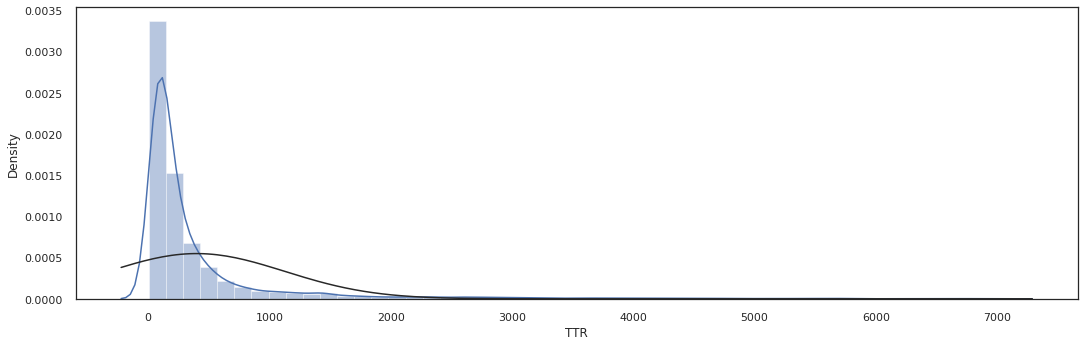

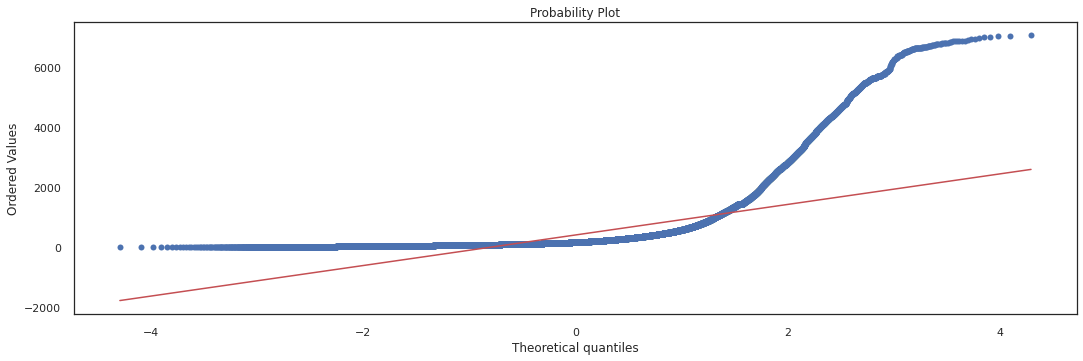

In [31]:
from scipy.stats import norm

sns.set(rc={'figure.figsize':(16,5)})
sns.set_style("white")

sns.distplot(ads['TTR'],fit=norm);
fig = plt.figure()
res = stats.probplot(ads['TTR'], plot=plt)

#### **Log Transformation of Tanget Variable (TTR)**

In [ ]:
# # Apply log e tranformation to the dataset
# ads['TTR'] = np.log(ads['TTR'])
# from scipy.stats import norm

# sns.set(rc={'figure.figsize':(16,5)})
# sns.set_style("white")

# sns.distplot(ads['TTR'],fit=norm);
# fig = plt.figure()
# res = stats.probplot(ads['TTR'], plot=plt)

In [32]:
%%time

#####################################################################
#####################################################################
#####################################################################
## FEATURE SELECTION : MAX VOTING REGIME ##
X = ads.drop(['TTR'],axis=1)
y = ads['TTR']

# ols = LinearRegression()
# ols.fit(X.values, y.values)
# pls = PLSRegression(n_components=15)
# pls.fit(X.values, y.values)
# rf = RandomForestRegressor(n_estimators=150, n_jobs = -1)
# rf.fit(X,y)
xg = lgb.LGBMRegressor(n_jobs=-1, max_depth=15)
xg.fit(X,y)

CPU times: user 12.9 s, sys: 373 ms, total: 13.3 s
Wall time: 1.85 s


LGBMRegressor(max_depth=15)

In [33]:
# ols_reg = pd.DataFrame({'Features': X.columns, 'Importance_Score_ols': ols.coef_}).sort_values(by='Importance_Score_ols',ascending=False)
# pls_reg = pd.DataFrame({'Features': X.columns, 'Importance_Score_PLS': pls.coef_.ravel()}).sort_values(by='Importance_Score_PLS',ascending=False)
# rftrees = pd.DataFrame({'Features': X.columns, 'Importance_Score_Random_Forest': rf.feature_importances_}).sort_values(by='Importance_Score_Random_Forest',ascending=False)
xgboost = pd.DataFrame({'Features': X.columns, 'Importance_Score_XGBoost': xg.feature_importances_}).sort_values(by='Importance_Score_XGBoost',ascending=False)


# ols_reg.reset_index(drop=True,inplace=True)
# pls_reg.reset_index(drop=True,inplace=True)
# rftrees.reset_index(drop=True,inplace=True)
xgboost.reset_index(drop=True,inplace=True)

# ols_reg = ols_reg.head(20)
# pls_reg = pls_reg.head(20)
# rftrees = rftrees.head(40)
xgboost = xgboost.head(60)

## **Feature Importance using Ordinary Least Square**

In [ ]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_ols", y="Features", data=ols_reg, palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : Lasso')

In [ ]:
display(ols_reg)

## **Feature Importance using Partial Least Square**

In [ ]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_PLS", y="Features", data=pls_reg , palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : PLS')

In [ ]:
display(pls_reg)

## **Feature Importance using XGBoost**

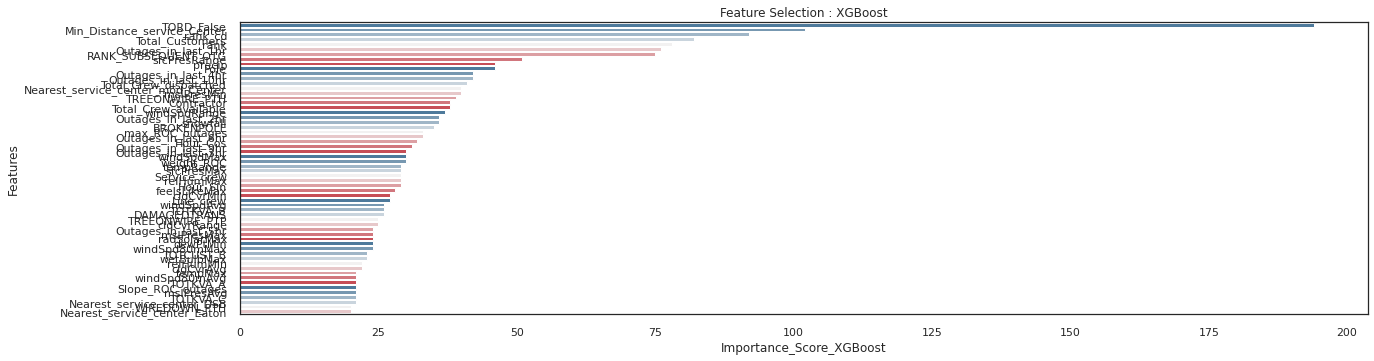

In [34]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_XGBoost", y="Features", data=xgboost, palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : XGBoost')

In [35]:
display(xgboost)

,Features,Importance_Score_XGBoost
0,TORD_False,194
1,Min_Distance_service_Center,102
2,rank_cd,92
3,Total_Customers,82
4,rank,78
5,Outages_in_last_1hr,76
6,RANK_SUBSEQUENT_OTG,75
7,sfcPresRange,51
8,precip,46
9,Pole,46


## **Feature Importance using Random Forest**

In [ ]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_Random_Forest", y="Features", data=rftrees, palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : Random Forest')

In [ ]:
display(rftrees)

## **Final Features Selected after Union (Max Voting Regime)**

In [36]:
# final_features = pd.DataFrame()
# final_features['XG Boost'] = xgboost.Features
# final_features['Random Forest'] = rftrees.Features
# final_features['OLS'] = ols_reg.Features
# final_features['PLS'] = pls_reg.Features


# display(final_features)

# final_features = do_union(list(xgboost.Features),list(rftrees.Features), list(ols_reg.Features), list(pls_reg.Features))
# print("/n Features selected:")
# print(len(final_features), "No. of Features Selected")
# print(final_features)

final_features = xgboost.Features.to_list()

### **View Data-set after feature selection**

In [ ]:
ads_v1 = ads[final_features]
ads_v1['TTR'] = ads['TTR']
display(ads_v1.head())

### **Correlation Matrix of Selected Variables**

In [ ]:
#whitegrid
sns.set_style('whitegrid')
#compute correlation matrix...
corr_matrix=ads_v1.corr(method='spearman')
#...and show it with a heatmap
#first define the dimension
plt.figure(figsize=(30,30))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(round(corr_matrix,2), mask=mask, cmap=cmap, center=0, vmax=1, vmin =-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### **BoxPlot of selected Variables**

In [ ]:
sns.set(rc={'figure.figsize':(20,15)})
sns.set_style("white")
for i, col in enumerate(list(ads_v1.columns.values)):
    plt.subplot(20,5,i+1)
    ads_v1.boxplot(col)
    plt.grid()
    plt.tight_layout()

### **Distribution Plot of selected Variables**

In [ ]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_style("white")
for i, col in enumerate(list(ads_v1.columns.values)):
    plt.subplot(20,5,i+1)
    sns.distplot(ads_v1[col], color='b', kde=True, label='data')
    plt.grid()
    plt.tight_layout()

# **Train-Test Split using sklearn**

In [88]:
X = ads[final_features]
X['Event'] = event_
y = ads['TTR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.drop(columns = ['Event'])
event_ = X_test['Event']
X_test = X_test.drop(columns = ['Event'])
print('\n')
print('\n')
print(len(X_train),len(X_test))
print(len(y_train),len(y_test))
print('\n')
print('\n')





63983 15996
63983 15996






# **Building Baseline CatBoost Model**
- CatBoost is an algorithm for gradient boosting on decision trees.

In [38]:
model_col = ['MODEL_NAME' , 'TRAIN_MSE', 'TRAIN_RMSE', 'TRAIN_MAE', 'TRAIN_MAPE', 'TRAIN_R2','TRAIN__Adj_R2', 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2','Test__Adj_R2']
model_result_df = pd.DataFrame(columns=model_col)
data_train_list = pd.DataFrame()
data_test_list = pd.DataFrame()
i=0

In [39]:
lgbm_base = lgb.LGBMRegressor()
lgbm_base.fit(X_train, y_train)

y_train_pred = lgbm_base.predict(X_train)
# y_train_pred = np.exp(y_train_pred)

y_test_pred = lgbm_base.predict(X_test)
# y_test_pred = np.exp(y_test_pred)

# y_train = np.exp(y_train)
# y_test = np.exp(y_test)

n = len(y_train)
p = len(final_features)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = rmse(y_train,y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
adj_r2_train = 1-(1-r2_train)*(n-1)/(n-p-1)
                   
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = rmse(y_test,y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)
r2_test = r2_score(y_test,y_test_pred)
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

data_train = pd.DataFrame({'Model':'LGBM Baseline', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'LGBM Baseline', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y_test)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['LGBM Baseline', mse_train, rmse_train, mae_train, mape_train, r2_train,adj_r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test, adj_r2_test]
i = i + 1

In [40]:
model_result_df.head()

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TRAIN__Adj_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2,Test__Adj_R2
0,LGBM Baseline,92754.055761,304.555505,177.037737,119.0987,0.825369,0.825205,122148.07545,349.496889,191.184214,119.600012,0.764535,0.764314


In [41]:
y_test_baseline = y_test
y_test_pred_baseline = y_test_pred

## **Random Forest Baseline: Actual vs Fitted PLot**

Text(0.5, 1.0, 'Actual vs Fitted : LGBM Baseline')

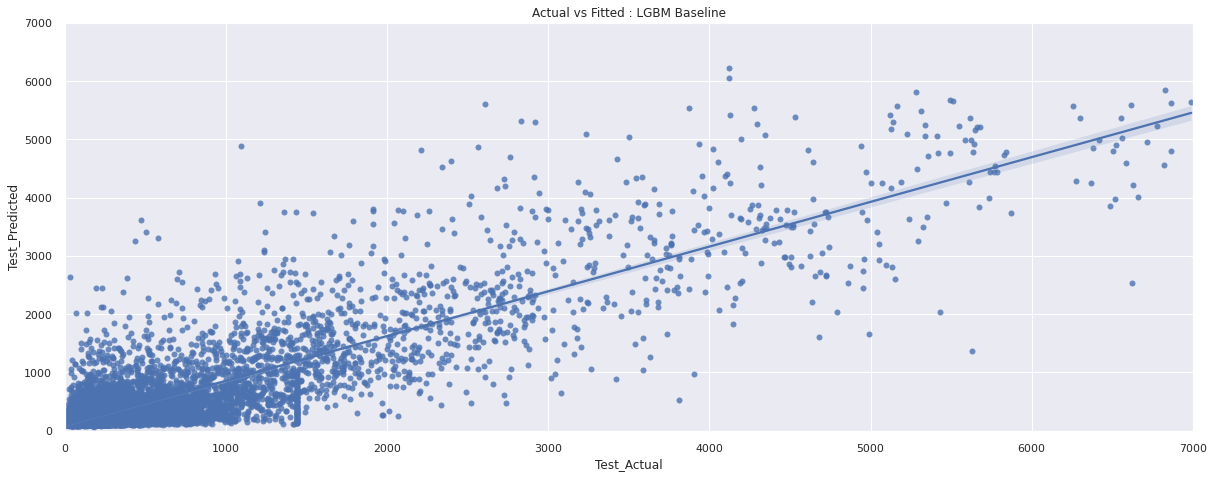

In [42]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='LGBM Baseline'])
ax.set_xlim(0,7000)
ax.set_ylim(0,7000)
ax.set_title('Actual vs Fitted : LGBM Baseline')

# **CATBoost Parameters**
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [43]:
pprint(lgbm_base.get_params())

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}


In [62]:
from sklearn.model_selection import RandomizedSearchCV

importance_type = ['split', 'gain']
max_bin  = [100, 200, 250, 300, 500]

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 3000, num = 20)]

# Number of features to consider at every split
learning_rate = [x for x in np.linspace(start = 0.01, stop = 0.3, num = 10)]

# Maximum number of levels in tree
max_depth = [-1, 3, 5, 7, 10, 12, 15, 17, 20]

# Minimum number of samples required to split a node
num_leaves = [int(x) for x in np.linspace(10, 60, num = 15)]

# Minimum number of samples required at each leaf node
loss_function = ["MAE", "RMSE"]

# Method of selecting samples for training each tree
min_split_gain  = [0, 1,2,3]

eval_metric = ["RMSE", "MAE"]

tree_learner = ['voting','serial']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'importance_type': importance_type,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'num_leaves': num_leaves,
               'min_split_gain ': min_split_gain ,
              'tree_learner': tree_learner,
              'max_bin': max_bin}

pprint(random_grid)

{'importance_type': ['split', 'gain'],
 'learning_rate': [0.01,
                   0.042222222222222223,
                   0.07444444444444444,
                   0.10666666666666666,
                   0.1388888888888889,
                   0.1711111111111111,
                   0.20333333333333334,
                   0.23555555555555557,
                   0.2677777777777778,
                   0.3],
 'max_bin': [100, 200, 250, 300, 500],
 'max_depth': [-1, 3, 5, 7, 10, 12, 15, 17, 20],
 'min_split_gain ': [0, 1, 2, 3],
 'n_estimators': [100,
                  252,
                  405,
                  557,
                  710,
                  863,
                  1015,
                  1168,
                  1321,
                  1473,
                  1626,
                  1778,
                  1931,
                  2084,
                  2236,
                  2389,
                  2542,
                  2694,
                  2847,
                  300

# **Random Search Training**
- The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively)
- More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

In [63]:
%%time

# Use the random grid to search for best hyperparameters
# First create the base model to tune
lgbm_rs = lgb.LGBMRegressor(silent = False)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lgbm_rs_random = RandomizedSearchCV(estimator = lgbm_rs, param_distributions = random_grid, n_iter = 150, cv = 2,
                                  verbose=5, scoring='neg_mean_absolute_error', random_state=1234, n_jobs = -1)

# Fit the random search model
lgbm_rs_random.fit(X_train, y_train)

Fitting 2 folds for each of 150 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.0min finished


[LightGBM] [Warning] min_split_gain is set=0.0, min_split_gain= will be ignored. Current value: min_split_gain=0.0
[LightGBM] [Warning] Unknown parameter: 2
[LightGBM] [Warning] min_split_gain is set=0.0, min_split_gain= will be ignored. Current value: min_split_gain=0.0
[LightGBM] [Warning] Unknown parameter: 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8906
[LightGBM] [Info] Number of data points in the train set: 63983, number of used features: 60
[LightGBM] [Info] Start training from score 399.653248
CPU times: user 2min 6s, sys: 1.3 s, total: 2min 8s
Wall time: 9min 7s


RandomizedSearchCV(cv=2, estimator=LGBMRegressor(silent=False), n_iter=150,
                   n_jobs=-1,
                   param_distributions={'importance_type': ['split', 'gain'],
                                        'learning_rate': [0.01,
                                                          0.042222222222222223,
                                                          0.07444444444444444,
                                                          0.10666666666666666,
                                                          0.1388888888888889,
                                                          0.1711111111111111,
                                                          0.20333333333333334,
                                                          0.23555555555555557,
                                                          0.2677777777777778,
                                                          0.3],
                                        'max_bin': [100, 2

In [69]:
print(lgbm_rs_random.best_params_)

{'tree_learner': 'voting', 'num_leaves': 45, 'n_estimators': 2694, 'min_split_gain ': 2, 'max_depth': -1, 'max_bin': 200, 'learning_rate': 0.01, 'importance_type': 'gain'}


#### **Building Random Search Best Model**

In [70]:
lgbm_rs = lgb.LGBMRegressor()
lgbm_rs.set_params(**lgbm_rs_random.best_params_)
lgbm_rs.fit(X_train, y_train)

y_train_pred = lgbm_rs.predict(X_train)
y_train_pred = y_train_pred

y_test_pred = lgbm_rs.predict(X_test)
y_test_pred = y_test_pred

n = len(y_train)
p = len(final_features)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = rmse(y_train,y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
adj_r2_train = 1-(1-r2_train)*(n-1)/(n-p-1)
                   
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = rmse(y_test,y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)
r2_test = r2_score(y_test,y_test_pred)
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

data_train = pd.DataFrame({'Model':'LGBM Random Search', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'LGBM Random Search', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y_test)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['LGBM Random Search', mse_train, rmse_train, mae_train, mape_train, r2_train,adj_r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test, adj_r2_test]
i = i + 1

[LightGBM] [Warning] min_split_gain is set=0.0, min_split_gain= will be ignored. Current value: min_split_gain=0.0
[LightGBM] [Warning] Unknown parameter: 2


KeyboardInterrupt: 

In [66]:
model_result_df.head()

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TRAIN__Adj_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2,Test__Adj_R2
0,LGBM Baseline,92754.055761,304.555505,177.037737,119.098700,0.825369,0.825205,122148.075450,349.496889,191.184214,119.600012,0.764535,0.764314
1,LGBM Random Search,53408.110625,231.101949,145.122462,106.904471,0.899447,0.899352,119002.403903,344.967250,185.974691,114.082243,0.770599,0.770384


In [67]:
y_test_random_search = y_test
y_test_pred_random_search = y_test_pred
# y_train = np.log(y_train)
# y_test = np.log(y_test)

#### **Random Forest Random Search: Actual vs Fitted PLot**

Text(0.5, 1.0, 'Actual vs Fitted : CATB Random Search')

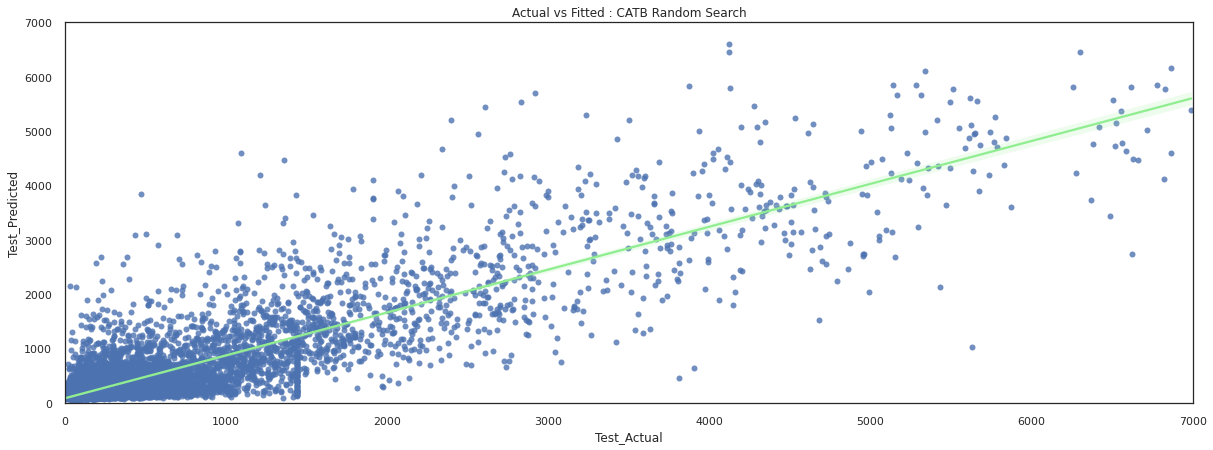

In [68]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("white")
ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='LGBM Random Search'], line_kws={"color": "lightgreen"})
ax.set_xlim(0,7000)
ax.set_ylim(0,7000)
ax.set_title('Actual vs Fitted : CATB Random Search')

# **Grid Search with Cross Validation**
- Random search allowed us to narrow down the range for each hyperparameter
- Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try
- We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define.

In [71]:
print(lgbm_rs_random.best_params_)

{'tree_learner': 'voting', 'num_leaves': 45, 'n_estimators': 2694, 'min_split_gain ': 2, 'max_depth': -1, 'max_bin': 200, 'learning_rate': 0.01, 'importance_type': 'gain'}


In [82]:
importance_type = ['gain']
max_bin  = [200]

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2000, stop = 3000, num = 5)]

# Number of features to consider at every split
learning_rate = [x for x in np.linspace(start = 0.01, stop = 0.05, num = 4)]

# Maximum number of levels in tree
max_depth = [-1, 2, 4]

# Minimum number of samples required to split a node
num_leaves = [int(x) for x in np.linspace(40, 60, num = 4)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'importance_type': importance_type,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'num_leaves': num_leaves,
              'max_bin': max_bin}

pprint(random_grid)

{'importance_type': ['gain'],
 'learning_rate': [0.01, 0.023333333333333334, 0.03666666666666667, 0.05],
 'max_bin': [200],
 'max_depth': [-1, 2, 4],
 'n_estimators': [2000, 2250, 2500, 2750, 3000],
 'num_leaves': [40, 46, 53, 60]}


In [ ]:
from sklearn.model_selection import GridSearchCV

# First create the base model to tune
lgbm_gs = lgb.LGBMRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lgbm_gs_p = GridSearchCV(estimator = lgbm_gs, param_grid = random_grid, cv = 2,
                                  verbose=5, scoring='neg_mean_absolute_error', n_jobs = -1)

# Fit the random search model
lgbm_gs_p.fit(X_train, y_train)

Fitting 2 folds for each of 240 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 41.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 44.3min finished


GridSearchCV(cv=2, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'importance_type': ['gain'],
                         'learning_rate': [0.01, 0.023333333333333334,
                                           0.03666666666666667, 0.05],
                         'max_bin': [200], 'max_depth': [-1, 2, 4],
                         'n_estimators': [2000, 2250, 2500, 2750, 3000],
                         'num_leaves': [40, 46, 53, 60]},
             scoring='neg_mean_absolute_error', verbose=5)

In [86]:
print(lgbm_gs_p.best_params_)

{'importance_type': 'gain', 'learning_rate': 0.01, 'max_bin': 200, 'max_depth': -1, 'n_estimators': 3000, 'num_leaves': 60}


{'importance_type': 'gain', 'learning_rate': 0.01, 'max_bin': 200, 'max_depth': -1, 'n_estimators': 3000, 'num_leaves': 60}

#### **Building Grid Search Best Model**

In [92]:
lgbm_gs = lgb.LGBMRegressor(tree_learner = 'voting',min_split_gain = 2)
lgbm_gs.set_params(**lgbm_gs_p.best_params_)
lgbm_gs.fit(X_train, y_train)

y_train_pred = lgbm_gs.predict(X_train)
y_train_pred = y_train_pred

y_test_pred = lgbm_gs.predict(X_test)
y_test_pred = y_test_pred

n = len(y_train)
p = len(final_features)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = rmse(y_train,y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
adj_r2_train = 1-(1-r2_train)*(n-1)/(n-p-1)
                   
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = rmse(y_test,y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)
r2_test = r2_score(y_test,y_test_pred)
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

data_train = pd.DataFrame({'Model':'LGBM Grid Search', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'LGBM Grid Search', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y_test)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['LGBM Grid Search', mse_train, rmse_train, mae_train, mape_train, r2_train,adj_r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test, adj_r2_test]
i = i + 1

In [93]:
model_result_df

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TRAIN__Adj_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2,Test__Adj_R2
0,LGBM Baseline,92754.055761,304.555505,177.037737,119.098700,0.825369,0.825205,122148.075450,349.496889,191.184214,119.600012,0.764535,0.764314
1,LGBM Random Search,53408.110625,231.101949,145.122462,106.904471,0.899447,0.899352,119002.403903,344.967250,185.974691,114.082243,0.770599,0.770384
2,LGBM Grid Search,41672.784998,204.139131,131.672354,100.994450,0.921541,0.921468,118868.925363,344.773731,184.894154,112.907538,0.770856,0.770641
3,LGBM Grid Search,41672.784998,204.139131,131.672354,100.994450,0.921541,0.921468,118868.925363,344.773731,184.894154,112.907538,0.770856,0.770641


In [ ]:
data_train_list.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_Curated_Datasets/Train_Data_DPL_DataRobo_RF_Ckt_lvl_OT_10292020_1.csv')
data_test_list.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_Curated_Datasets/Test_Data_DPL_Datarobo_RF_Ckt_lvl_OT_10292020_1.csv')

In [94]:
y_test_grid_search = y_test
y_test_pred_grid_search = y_test_pred


#### **Random Forest Grid Search: Actual vs Fitted Plot**

Text(0.5, 1.0, 'Actual vs Fitted : Random Forest Grid Search CV')

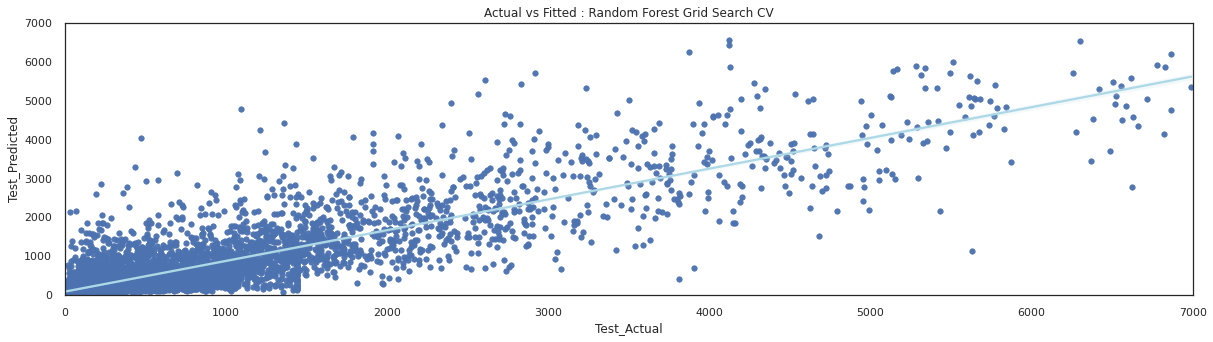

In [96]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='LGBM Grid Search'], line_kws={"color": "lightblue"})
ax.set_xlim(0,7000)
ax.set_ylim(0,7000)
ax.set_title('Actual vs Fitted : Random Forest Grid Search CV')

In [ ]:
data_train_list.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_Curated_Datasets/Train_Data_DPL_2.3_modified_Catboost20201122.csv')
data_test_list.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_Curated_Datasets/Train_Data_DPL_2.3_modified_Catboost_20201122.csv')

# **Selecting the best model**

In [ ]:
model_result_df

## **Model business metric** Storm + Bluesky

In [ ]:
y_test_pred = y_test_pred_random_search
y_test = y_test_random_search

business_KPI = customer_metrics(y_test,y_test_pred)
# y_train = np.log(y_train)
# y_test = np.log(y_test)
# y_test_pred = np.log(y_test_pred)

df_percentage = np.round(business_KPI*100/business_KPI.iloc[-1, -1], 1)
df_percentage = df_percentage.fillna(0)
df_percentage = df_percentage.astype(str) + "%"
df_percentage

## Splitting the metric in Storm and Blue sky events

In [ ]:
df_result = pd.DataFrame(data={'y_test': y_test, 'y_test_pred': y_test_pred , 'EVENT': event_})
# df_result.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_Curated_Datasets/Testdata_DPL_Datarobo_RF_Ckt_lvl_10292020_1.csv')
model_col = ['EVENT' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE']
best_model_result_df = pd.DataFrame(columns=model_col)
i=0

In [ ]:
mse_test = mean_squared_error(df_result.y_test, df_result.y_test_pred)
rmse_test = rmse(df_result.y_test, df_result.y_test_pred)
mae_test = mean_absolute_error(df_result.y_test, df_result.y_test_pred)
mape_test = mean_absolute_percentage_error(df_result.y_test, df_result.y_test_pred)
best_model_result_df.loc[i] = ['XGboost Random Search All', mse_test, rmse_test, mae_test, mape_test]
i = i + 1

mse_test = mean_squared_error(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
rmse_test = rmse(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
mae_test = mean_absolute_error(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
mape_test = mean_absolute_percentage_error(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
best_model_result_df.loc[i] = ['XGboost Random Search All',mse_test, rmse_test, mae_test, mape_test]
i = i + 1

mse_test = mean_squared_error(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
rmse_test = rmse(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
mae_test = mean_absolute_error(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
mape_test = mean_absolute_percentage_error(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
best_model_result_df.loc[i] = ['XGboost Random Search All', mse_test, rmse_test, mae_test, mape_test]
i = i + 1

best_model_result_df

### Residual plot

#### Storm + Bluesky

In [ ]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.regplot(x="y_test", y="y_test_pred", data=df_result, line_kws={"color": "lightblue"})
ax.set_xlim(0,7000)
ax.set_ylim(0,7000)
ax.set_title('Actual vs Fitted : Random Forest Baseline')
ax.set(xlabel='Actual TTR', ylabel='Predicted TTR')

#### Storm

In [ ]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.regplot(x="y_test", y="y_test_pred", data=df_result[df_result.EVENT == 'STORM'], line_kws={"color": "lightblue"})
ax.set_xlim(0,7000)
ax.set_ylim(0,7000)
ax.set_title('Actual vs Fitted : Random Forest Baseline')
ax.set(xlabel='Actual TTR', ylabel='Predicted TTR')

#### Bluesky

In [ ]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.regplot(x="y_test", y="y_test_pred", data=df_result[df_result.EVENT == 'BLUE SKY'], line_kws={"color": "lightblue"})
ax.set_xlim(0,1500)
ax.set_ylim(0,1500)
ax.set_title('Actual vs Fitted : Random Forest Baseline')
ax.set(xlabel='Actual TTR', ylabel='Predicted TTR')

## Business metrics for Storm Events

In [ ]:
business_KPI = customer_metrics_storm(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
df_percentage = np.round(business_KPI*100/business_KPI.iloc[-1, -1], 1)
df_percentage = df_percentage.fillna(0)
df_percentage = df_percentage.astype(str) + "%"
df_percentage.loc[['0-120','120-240','240-360','360-480','480-600','600-720','720-840','840-960','960-1080','1080-1200','1200-1320','1320-1440','>1440'],
                  ['0-120','120-240','240-360','360-480','480-600','600-720','720-840','840-960','960-1080','1080-1200','1200-1320','1320-1440','>1440']]

## Business metrics for Blue sky Events

In [ ]:
business_KPI = customer_metrics(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
df_percentage = np.round(business_KPI*100/business_KPI.iloc[-1, -1], 1)
df_percentage = df_percentage.fillna(0)
df_percentage = df_percentage.astype(str) + "%"
df_percentage

## **Saving Model Object using Pickle File**

In [ ]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='aes-datahub-0002')
fs.ls('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles')
with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/DPL_ADSv2.3_modified_Catboost11232020_base.pkl', 'wb') as f:
    pickle.dump(cat_base, f)
    
fs = gcsfs.GCSFileSystem(project='aes-datahub-0002')
fs.ls('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles')
with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/DPL_ADSv2.3_modified_Catboost11232020_RS.pkl', 'wb') as f:
    pickle.dump(cat_rs, f)

## **Load Model Object using Pickle File**

In [ ]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='aes-datahub-0002')

with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/DPL_ADSv2.3_modified_Catboost11232020_RS.pkl', 'rb') as f:
    rf_model = pickle.load(f)

# **Nov 15th Out of Sample Validation**

In [97]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
from datetime import datetime
from datetime import date
import csv
import matplotlib.pyplot as plt
import math
import regex as re
from scipy.stats import linregress
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
from IPython.display import display_html
warnings.filterwarnings('ignore')
%matplotlib inline

### Reading Dataset

In [98]:
df_all = pd.read_csv('gs://aes-analytics-0002-curated/DPL/Backfilling/DPL_outage_20201115.csv')

In [99]:
def feature_add(group):
    group = group.reset_index(drop = True)
    x = [group.Outages_in_last_1hr[0],group.Outages_in_last_2hr[0],group.Outages_in_last_3hr[0],group.Outages_in_last_4hr[0],group.Outages_in_last_5hr[0]
        ,group.Outages_in_last_6hr[0],group.Outages_in_last_7hr[0],group.Outages_in_last_8hr[0],group.Outages_in_last_9hr[0],group.Outages_in_last_10hr[0]]
    y = [1,2,3,4,5,6,7,8,9,10]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    group['Slope_outages'] = slope
    
    ROC = [abs(group.Outages_in_last_1hr[0] - group.Outages_in_last_2hr[0]),abs(group.Outages_in_last_2hr[0] - group.Outages_in_last_3hr[0]),
           abs(group.Outages_in_last_3hr[0] - group.Outages_in_last_4hr[0]),abs(group.Outages_in_last_4hr[0] - group.Outages_in_last_5hr[0]),
           abs(group.Outages_in_last_5hr[0] - group.Outages_in_last_6hr[0]),abs(group.Outages_in_last_6hr[0] - group.Outages_in_last_7hr[0]),
           abs(group.Outages_in_last_7hr[0] - group.Outages_in_last_8hr[0]),abs(group.Outages_in_last_8hr[0] - group.Outages_in_last_9hr[0]),
           abs(group.Outages_in_last_9hr[0] - group.Outages_in_last_10hr[0])]
    y = [1,2,3,4,5,6,7,8,9]
    slope, intercept, r_value, p_value, std_err = linregress(ROC, y)
    group['Slope_ROC_outages'] = slope
    
    group['max_ROC_outages'] = max(ROC)
    group['max_index_ROC'] = 1+ROC.index(max(ROC))    
    group['weight_ROC'] = group['max_ROC_outages'] * group['max_index_ROC']*0.1
    return group

df_all = df_all.groupby(['OUTAGE_ID'], as_index = False).apply(feature_add).reset_index(drop = True)

df_all['TIME_OF_FIRST_CALL'] = pd.to_datetime(df_all['TIME_OF_FIRST_CALL'], errors = 'coerce')
df_all.sort_values(by=['TIME_OF_FIRST_CALL'], inplace = True)

# Total Customers
df_all['Total_Customers'] = df_all['TOTCUST_A'] + df_all['TOTCUST_B'] + df_all['TOTCUST_C']

# Total Key Customers
df_all['Total_Key_Customers'] = df_all['LFS_CUSTS'] + df_all['MED_CUSTS'] + df_all['EMR_CUSTS'] + df_all['UTL_CUSTS'] + df_all['MAJ_CUSTS'] + df_all['GOV_CUSTS'] + df_all['LRT_CUSTS']

# Month Cycle Capture
df_all['Month_Sin'] = np.sin(df_all.TIME_OF_FIRST_CALL.dt.month*(2.*np.pi/24))
df_all['Month_Cos'] = np.cos(df_all.TIME_OF_FIRST_CALL.dt.month*(2.*np.pi/24))
df_all['Month_Sin'] = np.sin(df_all.TIME_OF_FIRST_CALL.dt.month*(2.*np.pi/24))
df_all['Month_Cos'] = np.cos(df_all.TIME_OF_FIRST_CALL.dt.month*(2.*np.pi/24))

# Pole Related Causes
df_all['Pole'] = df_all['WIREDOWN_PTH'] +  df_all['WIREDOWN_PTP'] + df_all['TREEONWIRE_PTH'] + df_all['TREEONWIRE_PTP'] + df_all['BROKENPOLE']

# Accounting for busiest service centers location
df_all['Nearest_service_center_mod'] = df_all.Nearest_service_center.apply(lambda x: "Center" if ( (x== 'DSB') | (x== 'North Dayton') ) else "Not_Center")

### Dummifying Categorical Variables

In [100]:
object_columns = df_all.loc[:, (df_all.dtypes == object) | (df_all.dtypes == bool)]
print(list(object_columns.columns))

# Dummifying one hot code encoding
df_all = pd.get_dummies(df_all, columns=['CONFIDENCE', 'weekday', 'Marker_Location', 'Nearest_service_center',
                                   'DEVICETYPE','Nearest_service_center_mod','VOLTAGE'])
print(df_all.shape)

# Dropping duplicate columns
df_all = df_all.loc[:,~df_all.columns.duplicated()]

print(df_all.shape)

['CIRCUIT', 'DEVICE', 'SORTNUMBER', 'OUTAGE_NAME', 'CONFIDENCE', 'REMARKS', 'ANALYZER', 'DATETIMEADDED', 'ECD', 'LASTUPDATE', 'Day_flag', 'DATE', 'weekday', 'Weekend_flag', 'Nearest_service_center', 'Marker_Location', 'DEVICETYPE', 'DEVICESIZE', 'TOPFUSE', 'VOLTAGE', 'UNDERGD', 'NORMALLYOPEN', 'timestampInit', 'Nearest_service_center_mod']
(757, 343)
(757, 333)


### Running on Nov 15th Events

In [102]:
df_all['Marker_Location_Marker 53'] = 0
df_all['weekday_Monday'] = 0


# Selecting Required Features
ads_15 = df_all[final_features]


# Running Predictions
y_pred_15_base = lgbm_gs.predict(ads_15)
# y_pred_15 = np.exp(y_pred_15)

### Adding Aligned Business Layer

In [103]:
def business_layer_add_addtional_time(predicted_values):
    '''
    Input - Prediction of Outages in minutes
    Output - If predicted values are less than 1440 min
    Add 45 mins to predictions, Else Add 360 mins to predictions
    '''
    new_pred_values = []
    for i in range(len(predicted_values)):
        if predicted_values[i] <= 1440:
            new_pred_values.append(predicted_values[i] + 45)
        elif predicted_values[i] > 1440:
            new_pred_values.append(predicted_values[i] + 360)
        else :
            new_pred_values.append(predicted_values[i])
    return new_pred_values

Y_TEST_PRED_base = business_layer_add_addtional_time(y_pred_15_base)

df_all['New_Model_Predictions_base'] = Y_TEST_PRED_base

### Predictions Distribution without business layer

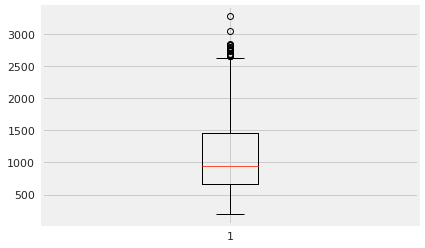

In [104]:
plt.boxplot(Y_TEST_PRED_base)
plt.show()

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Actual vs Fitted : CATB Baseline')

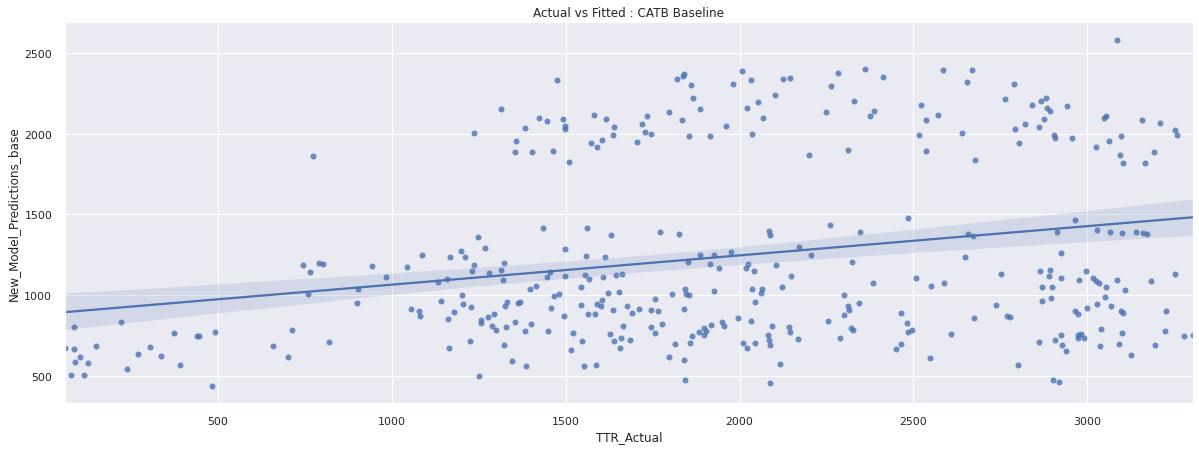

In [105]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="TTR_Actual", y="New_Model_Predictions_base", data=results_all)
# ax = sns.regplot(x="TTR_Actual", y="TTR_TCMS", data=results_all, color = "red")
ax.legend()
ax.set_title('Actual vs Fitted : CATB Baseline')

In [58]:
len(results_all[results_all.TTR_TCMS >= results_all.TTR_Actual])

37

In [108]:
len(results_all[results_all.New_Model_Predictions_base >= results_all.TTR_Actual])

74

In [60]:
len(results_all[results_all.TTR_TCMS >= results_all.New_Model_Predictions_base])

115

In [61]:
len(results_all[results_all.TTR_Actual >= results_all.New_Model_Predictions_base])

284

### Getting 15th Diagnostic Results

In [107]:
# Reading diagnostic table
diag_15 = pd.read_csv('gs://aes-analytics-0002-curated/DPL/Backfilling/Diagnostic_15th.csv')
diag_15 = diag_15[['OUTAGE_ID', 'TTR_TCMS','TIME_OF_FIRST_CALL', 'DATETIMERELEASED','ERT', 'TTR_Actual', 'TTR_Model',]]

# Combining Results
results_all = pd.merge(df_all[['OUTAGE_ID', 'New_Model_Predictions_base']], diag_15, how='inner', on='OUTAGE_ID')

# Comparison
print('Current Model MAE: ', mean_absolute_error(results_all.TTR_Actual, results_all.TTR_Model))
print('Current Model RMSE: ', rmse(results_all.TTR_Actual, results_all.TTR_Model))

print('\n','New Model base MAE: ', mean_absolute_error(results_all.TTR_Actual, results_all.New_Model_Predictions_base))
print('New Model base RMSE: ', rmse(results_all.TTR_Actual, results_all.New_Model_Predictions_base))

results_all_mo = results_all.dropna()
print('\n','TCMS Model MAE: ', mean_absolute_error(results_all_mo.TTR_Actual, results_all_mo.TTR_TCMS))
print('TCMS Model RMSE: ', rmse(results_all_mo.TTR_Actual, results_all_mo.TTR_TCMS))

Current Model MAE:  1476.1319407008084
Current Model RMSE:  1617.1795344985064

 New Model base MAE:  994.1091081263828
New Model base RMSE:  1203.9147683898634

 TCMS Model MAE:  962.3605226480837
TCMS Model RMSE:  1218.001545660926


In [ ]:
results_all.sort_values(by='New_Model_Predictions_base')

In [ ]:
import warnings
import logging
import datetime
import pandas as pd
import numpy as np
from pandas.io import gbq

PROJECT_ID = 'aes-analytics-0002'
DATASET = 'mds_outage_restoration'
TABLE = 'DPL_New_Model_15_3'

results_all['TTR_Model'] = results_all['New_Model_Predictions_base']
results_all.drop(columns=['New_Model_Predictions_base'], inplace = True)

In [ ]:
results_all.to_gbq("""{dataset}.{output_tbl}""".format(dataset=DATASET, output_tbl=TABLE),
           project_id=PROJECT_ID, chunksize=None, reauth=False, if_exists='replace',
           auth_local_webserver=False, table_schema=None, location=None,
           progress_bar=True, credentials=None)

## **Load Model Object using Pickle File**

In [ ]:
df_all = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_Curated_Datasets/DPL_circuitLevel_Master_dataset_v1.3.csv')
df_all = df_all[df_all.columns[:63]]
df_all['DATETIMESTART'] = pd.to_datetime(df_all['DATETIMESTART'], infer_datetime_format = True, errors = 'coerce')
df_all = df_all[df_all.DATETIMESTART.dt.year == 2020]
df_all['DATE'] = df_all['DATE'].str[:10]

df_weather = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_Curated_Datasets/DPL_all_marker_weather_data_2020.csv')
df_weather['timestamp'] = df_weather['timestamp'].str[:10]

df_all = pd.merge(df_all, df_weather, left_on = ['DATE','Marker_Location'], right_on = ['timestamp','Location'], how = 'inner')

df_all['tempRange'] = df_all['tempMax'] - df_all['tempMin']
df_all['windSpdRange'] = df_all['windSpdMax'] - df_all['windSpdMin']
df_all['sfcPresRange'] = df_all['sfcPresMax'] - df_all['sfcPresMin']
df_all['cldCvrRange'] = df_all['cldCvrMax'] - df_all['cldCvrMin']
df_all['relHumRange'] = df_all['relHumMax'] - df_all['relHumMin']

df_all['relHumRatio'] = df_all['relHumMax'] / df_all['relHumMin']
df_all['sfcPresRatio'] = df_all['sfcPresMax'] / df_all['sfcPresMin']
df_all['Nearest_service_center_Washington Court House'] = 0
df_all['Nearest_service_center_Eaton'] = 0
df_all['Nearest_service_center_Marysville'] = 0
df_all['weekday_Tuesday'] = 0
df_all['Marker_Location_Marker 15'] = 0
df_all['Marker_Location_Marker 4'] = 0
df_all['Marker_Location_Marker 18'] = 0
df_all['Marker_Location_Marker 11'] = 0
df_all['Marker_Location_Marker 15'] = 0
df_all['Marker_Location_Marker 17'] = 0
df_all['Marker_Location_Marker 8'] = 0
df_all['Marker_Location_Marker 7'] = 0
df_all['Marker_Location_Marker 14'] = 0
df_all['Marker_Location_Marker 39'] = 0
df_all['Marker_Location_Marker 21'] = 0
df_all['Marker_Location_Marker 33'] = 0

In [ ]:
event_ = df_all['EVENT']
df_all.shape

In [ ]:
df_all[df_all['EVENT'] == 'STORM'].shape

In [ ]:
X = df_all[final_features]
y = df_all.TTR

y_test_pred = rf_model.predict(X)

df_result = pd.DataFrame(data={'y_test': y, 'y_test_pred': y_test_pred , 'EVENT': event_})

model_col = ['EVENT' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'R2_Score']
validation_result_df = pd.DataFrame(columns=model_col)
i=0

In [ ]:
mse_test = mean_squared_error(df_result.y_test, df_result.y_test_pred)
rmse_test = rmse(df_result.y_test, df_result.y_test_pred)
mae_test = mean_absolute_error(df_result.y_test, df_result.y_test_pred)
mape_test = mean_absolute_percentage_error(df_result.y_test, df_result.y_test_pred)
r2_test = r2_score(df_result.y_test, df_result.y_test_pred)

validation_result_df.loc[i] = ['2020 Validation Storm + Blue sky', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

mse_test = mean_squared_error(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
rmse_test = rmse(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
mae_test = mean_absolute_error(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
mape_test = mean_absolute_percentage_error(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
r2_test = r2_score(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
validation_result_df.loc[i] = ['2020 Validation Storm', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

mse_test = mean_squared_error(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
rmse_test = rmse(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
mae_test = mean_absolute_error(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
mape_test = mean_absolute_percentage_error(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
r2_test = r2_score(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
validation_result_df.loc[i] = ['2020 Validation Blue sky', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

validation_result_df

## Business metrics for Storm + Blue sky Events

In [ ]:
business_KPI = customer_metrics(df_result.y_test, df_result.y_test_pred)
df_percentage = np.round(business_KPI*100/business_KPI.iloc[-1, -1], 1)
df_percentage = df_percentage.fillna(0)
df_percentage = df_percentage.astype(str) + "%"
df_percentage

## Business metrics for Storm Events

In [ ]:
business_KPI = customer_metrics_storm(df_result[df_result.EVENT == 'STORM'].y_test, df_result[df_result.EVENT == 'STORM'].y_test_pred)
df_percentage = np.round(business_KPI*100/business_KPI.iloc[-1, -1], 1)
df_percentage = df_percentage.fillna(0)
df_percentage = df_percentage.astype(str) + "%"
df_percentage
# df_percentage.loc[['0-120','120-240','240-360','360-480','480-600','1080-1200','>1440'],['0-120','120-240',]]

## Business metrics for Blue sky Events

In [ ]:
business_KPI = customer_metrics(df_result[df_result.EVENT == 'BLUE SKY'].y_test, df_result[df_result.EVENT == 'BLUE SKY'].y_test_pred)
df_percentage = np.round(business_KPI*100/business_KPI.iloc[-1, -1], 1)
df_percentage = df_percentage.fillna(0)
df_percentage = df_percentage.astype(str) + "%"
df_percentage

### Residual plot

#### Storm + Bluesky

In [ ]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.regplot(x="y_test", y="y_test_pred", data=df_result, line_kws={"color": "lightblue"})
ax.set_xlim(0,800)
ax.set_ylim(0,800)
ax.set_title('Actual vs Fitted : Random Forest Baseline')
ax.set(xlabel='Actual TTR', ylabel='Predicted TTR')

#### Storm

In [ ]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")

ax = sns.regplot(x="y_test", y="y_test_pred", data=df_result[df_result.EVENT == 'STORM'], line_kws={"color": "lightblue"})
ax.set_xlim(0,800)
ax.set_ylim(0,800)
ax.set_title('Actual vs Fitted : Random Forest Baseline')
ax.set(xlabel='Actual TTR', ylabel='Predicted TTR')

#### Bluesky

In [ ]:
sns.set(rc={'figure.figsize':(18,5)})
sns.set_style("white")
ax = sns.regplot(x="y_test", y="y_test_pred", data=df_result[df_result.EVENT == 'BLUE SKY'], line_kws={"color": "lightblue"})
ax.set_xlim(0,800)
ax.set_ylim(0,800)
ax.set_title('Actual vs Fitted : Random Forest Baseline')
ax.set(xlabel='Actual TTR', ylabel='Predicted TTR')

In [ ]:
df_result.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/DPL_Curated_Datasets/Datarobo_RF_Model_2020_Results_Ckt_lvl_OT_1.csv')